In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

data_dir = Path('/groups/douglase/kians-data-files/disk-processing/')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

polaxis = 10

ndisk = 128
disk_pixelscale_mas = 10.5*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

# Do the matrix multiplication

In [14]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_575_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/groups/douglase/kians-data-files/disk-processing/ipsfs/hlc_575_ipsfs_072022.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

In [4]:
np.min(ipsf_matrix)

-0.001627652357556473

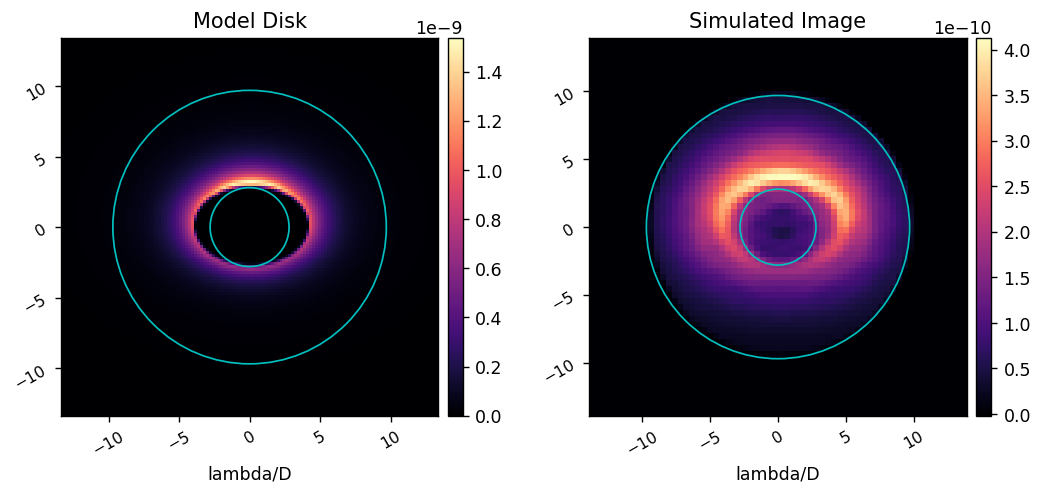

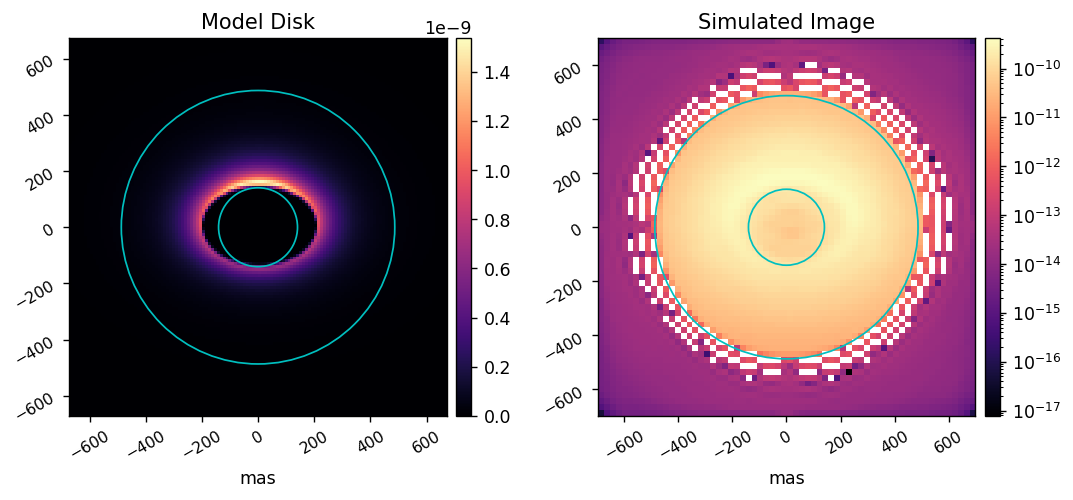

In [15]:
disk_fpath = data_dir/'disks'/'Debes_Models_07_2022'/'annulus_inc45_r0.20.fits'
disk = misc.pad_or_crop(fits.getdata(disk_fpath), ndisk)

disk_sim = np.reshape( ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim,
               'Model Disk', 'Simulated Image',
               lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=psf_pixelscale_lamD, 
               patches1=patches1, patches2=patches2 )

patches1 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim,
               'Model Disk', 'Simulated Image',
               lognorm1=False, lognorm2=True, 
               pxscl1=disk_pixelscale_mas, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

In [12]:
np.unravel_index(np.argmin(disk_sim), shape=(64,64))

misc.myimshow()

(39, 10)